# Spatial Inequality


## Introduction

Social and economic inequality is often at the top of policy makers' agendas.
It has always drawn considerable attention in academic circles. Currently, 
the world is extremely unequal, stratified, and segregated; no matter the 
society or economic system, inequality is at a high point. Much of the focus
has been on *interpersonal income inequality*, yet there is a growing recognition
that the question of *interregional income inequality* requires further 
attention as the growing gaps between poor and rich regions have been identified
as key drivers of political polarization in developing and developed countries
{cite}`Rodriguez_Pose_2018`.

Indeed, while the two literatures (personal and regional inequality) are
related, they have developed in a largely parallel fashion with limited
cross-fertilization. In this notebook, we examine how a spatially explicit focus
can provide insights on inequality and its dynamics. We also show the lineage of
regional inequality analysis to make explicit the linkage between it and the
older literature on personal inequality analysis.

We begin with an introduction to classic methods for interpersonal income
inequality analysis and how they have been adopted to the question of regional
inequalities. These include a number of graphical tools along side familiar
indices of inequality. As we discuss more fully, the use of these classical
methods in spatially referenced data, while useful in providing insights on some
of the aspects of spatial inequality, fails to fully capture the nature of
geographical disparities and their dynamics. Thus, we next move to spatially
explicit measures for regional inequality analysis. The notebook closes with
some recent extensions of some classical measures to more fully examine the
spatial dimensions of regional inequality dynamics.


## Data: US State Per-Capita Income 1969-2017


For this chapter, we focus on the case of the United States from 1969 to 2017. Specifically, we will analyze median incomes at the county level, examining the trends both in terms of how individual counties, states, or regions get richer or poorer, as well as how the overall distribution of income moves, skews, or spreads out. 


---

In [1]:
%matplotlib inline

import seaborn
import pandas
import geopandas
import pysal
import numpy
import mapclassify
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 5

In [2]:
pci_df = geopandas.read_file('../data/us_county_income/uscountypcincome.gpkg')
pci_df.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2012,2013,2014,2015,2016,2017,index,IndustryCl,Descript_1,geometry
0,55,111,01581115,55111,Sauk,Sauk County,06,H1,G4020,357,...,39988,40655,42668,44255,44540,45847,NaN,None,None,"POLYGON ((-90.19196 43.55500, -90.31107 43.553..."
1,55,093,01581107,55093,Pierce,Pierce County,06,H1,G4020,378,...,39121,39367,41626,43539,43488,44636,NaN,None,None,"POLYGON ((-92.69454 44.68874, -92.73204 44.714..."
2,55,063,01581091,55063,La Crosse,La Crosse County,06,H1,G4020,None,...,41759,41230,43637,45067,45985,47134,NaN,None,None,"POLYGON ((-91.34774 43.91196, -91.42519 43.984..."
3,55,033,01581076,55033,Dunn,Dunn County,06,H1,G4020,232,...,35909,35940,36752,36835,37151,38345,NaN,None,None,"POLYGON ((-92.13538 44.94481, -92.15646 45.209..."
4,55,053,01581086,55053,Jackson,Jackson County,06,H1,G4020,None,...,39319,38620,40260,41189,41181,43185,NaN,None,None,"POLYGON ((-91.16601 44.33510, -91.16562 44.596..."


Inspection of the head of the data frame reveals that the years appear as columns in the data set, together with information about the particular record.
This format is an example of a [*wide* longitudinal data set](https://en.wikipedia.org/wiki/Wide_and_narrow_data).
In wide-format data, each column represents a different time period, meaning that each row represents a set of measurements made about the same "entity" over time time (as well as any unique identifying information about that entity.)
This contrasts with a *narrow* or *long* format, where each row describes an entity at a specific point in time. 
Long data results in significant duplication for records and is generally worse for data storage. However, long form data is sometimes a more useful format when manipulating and analyzing data, as {cite}`Wickham_2014` discusses. Nonetheless, when analyzing *trajectories*, that is, the paths that entities take over time, wide data is more useful, and we will use that here. 

In this data, we have 3076 counties across 49 years, as well as 28 extra columns that describe each county. 
<!-- 
ljw: we (1) don't discuss wide vs. long anywhere else in the book and (2) don't ever show a wide-to-long pivot using something like pandas.wide_to_long... We also don't need the LineCode filtering, since the final dataframe is already filtered by LineCode so that all LineCode==3.
-->


In [3]:
pci_df.shape

(3076, 77)

As an example, we can see the first few years for Jackson Counti, Mississippi below:

In [4]:
pci_df.query('NAME == "Jackson" & STATEFP == "28"')

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2012,2013,2014,2015,2016,2017,index,IndustryCl,Descript_1,geometry
1417,28,059,00695753,28059,Jackson,Jackson County,06,H1,G4020,None,...,34586,34494,34905,35429,35890,36449,NaN,None,None,"POLYGON ((-88.82351 30.38205, -88.88453 30.677..."


## Global Inequality

We begin our examination of inequality by focusing on several global measures of income inequlity. Here, "global" means that the measure is concerned with the overall nature of inequality within the income distribution. That is, these measures focus on the direct disparity between rich and poor, considering nothing about where the rich and poor live. Several classic measures of inequality are available for this purpose. 

In general terms, measures of inequality focus on the dispersion present in an income distribution. In the case of regional or spatial inequality, the distributions describe the average or per-capita incomes for spatial units, such as for counties, census tracts, or regions. For our US counties data, we can visualize the distribution of per capita incomes for the first year in the sample as follows:

<AxesSubplot:xlabel='1969', ylabel='Count'>

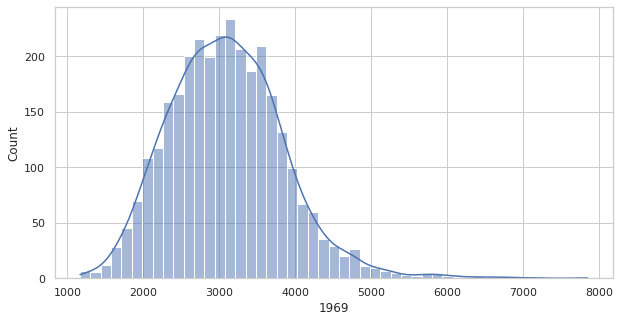

In [5]:
seaborn.set_theme(style='whitegrid')
seaborn.histplot(x=pci_df['1969'], kde=True)

Looking at this distribution, notice that the right side of the distribution is much longer than the left side. This long right tail is a prominent feature of the distribution, and is common in the study of incomes, as it reflects the fact that within a single income distribution, the super-rich are generally much more wealthy than the super-poor are deprived. 

A key point to keep in mind here is that the unit of measurement in this data is a spatial aggregate of individual incomes. Here, we are using the per-capita incomes for each county. By contrast, in the wider inequality literature, the observational unit is typically a household or individual. In the latter distributions, the degree of skewness is often more pronounced. This difference arises from the smoothing that is intrinsic to aggregation: the regional distributions are based on averages obtained from the individual distributions, and so the extremely high-income individuals are averaged with the rest of their county. 

The kernel density estimate (or histogram) is a powerful visualization device that captures the overall morphology of the *feature* distribution for this measure of income. At the same time, the density is silent on the underlying *geographic distribution* of county incomes. We can look at this second view of the distribution using a choropleth map. To construct this, we can use the standard `geopandas` plotting tools. First, though, we will clean up the data for mapping. 

In [6]:
pci_df = (pci_df.set_crs(epsg=4326) # US Census default projection
                .to_crs(epsg=5070)) # Albers Equal Area North America

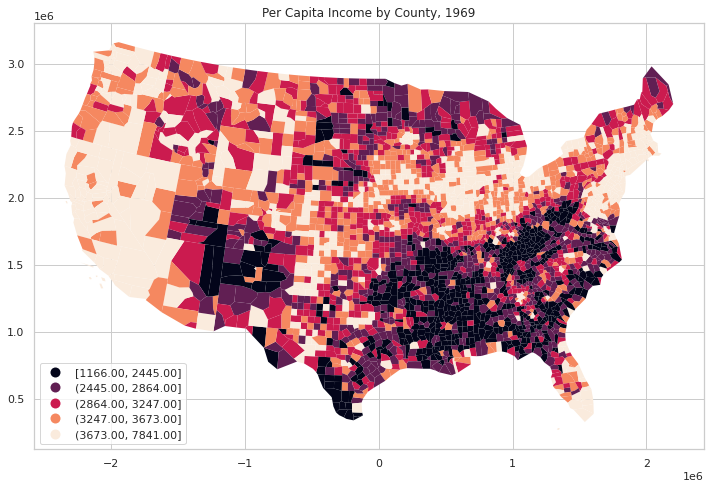

In [7]:
pci_df.plot(column='1969', scheme='Quantiles', 
            legend=True, edgecolor='none',
            legend_kwds={'loc': 'lower left'}, 
            figsize=(12, 12))
plt.title('Per Capita Income by County, 1969')
plt.show()

The choropleth and the kernel density provide different visual depictions of the distribution of county incomes. The kernel density estimate is a *feature*-based representation, and the map is a *geographic* representation. Both are useful for developing an understanding of the overall. To gain more specific insights on the level of inequality in the distribution, we'll discuss a few inequality indices common in econometrics. 

### 20:20 Ratio

One commonly used measure of inequality in a distribution is the so called 20:20 ratio, which is defined as the ratio of the incomes at the 80th percentile over that at the 20th percentile: 
<!-- #endregion -->

In [39]:
top20, bottom20 = pci_df['1969'].quantile([.8, .2])

In [40]:
top20/bottom20

1.5022494887525562

In 1969 the richest 20% of the counties had an income that was 1.5 times the poorest 20% of the counties. The 20:20 ratio has the advantage of being robust to outliers at the top and the bottom of the distribution. 

We can examine the dynamics of this global inequality measure by creating a simple function to apply to all years in our time series:

In [46]:
def ineq_2020(values):
    top20, bottom20 = values.quantile([.8, .2])
    return top20/bottom20

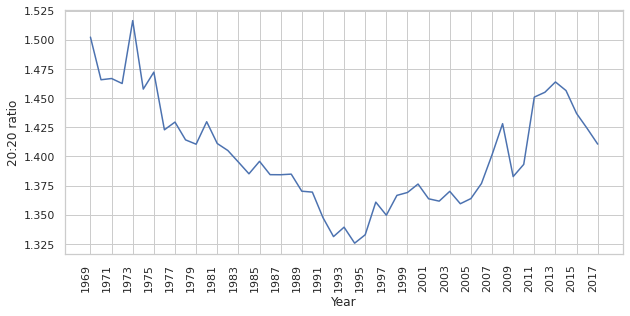

In [67]:
years = numpy.arange(1969, 2018).astype(str)
ratio_2020 = pci_df[years].apply(ineq_2020, axis=0)
ax = plt.plot(years, ratio_2020)
figure = plt.gcf()
plt.xticks(years[::2])
plt.ylabel("20:20 ratio")
plt.xlabel("Year")
figure.autofmt_xdate(rotation=90)
plt.show()

The ratio has a U-shaped pattern over time, bottoming out around 1994 after a long decline. Post 1994, however, the 20:20 ratio indicates there is increasing inequality up until 2013, where there is a turn towards lower income inequality between the counties.

For other classic measures of inequality, we will use the `inequality` package from `pysal`:

In [68]:
from pysal.explore import inequality

### Gini Index

The Gini index is a longstanding measure of inequality. It can be derived in a number of ways. One of the simplest ways to define the Gini Curve is *via* the cumulative wealth distribution, called the *Lorenz* curve. This represents the share of people on the horizontal axis and the share of overall wealth on the vertical axis. 

With the Lorenz curve, we can define what a "perfectly equal" society would look like: a straight line connecting $(0,0)$ and $(1,1)$ is called the *line of perfect equality*, and represents the case where $p$% of the population owns exactly $p$% of the wealth. For example, this might mean that 50% of the population earns exactly 50% of the income, or 90% of the population owns 90% of the wealth. The main idea is that the share of wealth or income is exactly proportional to the share of population that owns that wealth or earns that income.  

With this, we can define the Gini index as the ratio of the area between the line of perfect equality and the Lorenze curve over the area below the line of equality. 

We can construct one of the income curves for 1969 by first computing the share of population below each observation:

In [74]:
N = len(pci_df)
share_of_population = numpy.arange(1, N+1)/N

Then, we need to find out how many incomes are *smaller than* the values for each observation. Empirically, this can be computed by first sorting the incomes:

In [75]:
incomes = pci_df['1969'].sort_values()

Then, we need to find the overall fraction of income at (or below) each value in the sorted incomes. 

To convert the raw incomes to income shares, we simply divide by the total income:

In [86]:
shares = incomes / incomes.sum()

Then, we construct the *cumulative sum* of these shares, which reflects the sum of all observations up to the current one:
$$ \texttt{cumsum(v, k)} = \sum_{i=1}^k v_i$$

In [87]:
cumulative_share = shares.cumsum()

With this, we can plot both curves using the standard `matplotlib` call:

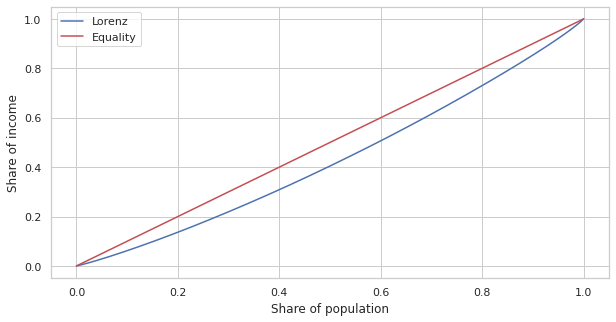

In [94]:
f, ax = plt.subplots()
ax.plot(share_of_population, cumulative_share, label='Lorenz')
ax.plot((0,1), (0,1), color='r', label='Equality')
ax.set_xlabel('Share of population')
ax.set_ylabel('Share of income')
ax.legend()
plt.show()

The blue line is the Lorenze curve for county incomes in 1969. The Gini index is the area between it and the 45-degree line of equality shown in red, all standardized by the area underneath the line of equality.

To examine how inequality evolves over time, we can create a function to compute the Lorenze curve for arbitrary inputs. We'll use this to plot the Lorenz curves for each year.

In [85]:
def lorenz(y):
    incomes = numpy.sort(y)
    income_shares = (y / y.sum()).cumsum()
    N = y.shape[0]
    pop_shares = numpy.arange(1, N+1)/N
    return pop_shares, income_shares

and then call this for each year in our sample:

In [25]:
lorenz_curves = np.array([ lorenz(pci_df[str(year)]) for year in years])

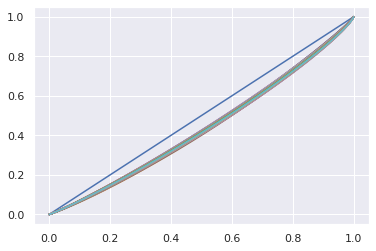

In [26]:
f, ax = plt.subplots()
ax.plot(Fn,Fn)
for c in lorenz_curves:
    ax.plot(Fn, c)


The compression of the Lorenze curves makes it difficult to ascertain the temporal pattern in inequality. Focusing explicilty on the Gini coefficients may shed more light on this evolution:

In [27]:
g69 = inequality.gini.Gini(pci_df['1969'].values)


In [28]:
g69.g

0.13556175504269904

In [29]:
years = [str(y) for y in range(1969, 2018)]
ginis = numpy.array([inequality.gini.Gini(pci_df[year].values).g for year in years])
years = numpy.array([int(y) for y in years])

In [30]:
gini_df = pandas.DataFrame(data = numpy.hstack([[years, ginis]]).T, columns=['Year', 'Gini'])
gini_df['Year'] = gini_df['Year'].astype(int)
gini_df.head()

,Year,Gini
0,1969,0.135562
1,1970,0.130076
2,1971,0.128540
3,1972,0.129126
4,1973,0.142166


In [31]:
gini_df.index = pandas.to_datetime(gini_df['Year'], format="%Y")
gini_df = gini_df.drop(columns=["Year"])

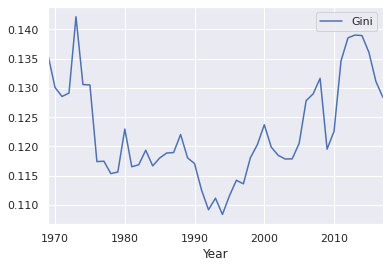

In [32]:
_ = gini_df.plot(y=["Gini"])

### Theil's index

A third commonly used measure of inequality is Theil's $T$ given as:
$$T = \sum_{i=1}^m \left( \frac{y_i}{\sum_{i=1}^m y_i} \ln \left[ m \frac{y_i}{\sum_{i=1}^m y_i}\right] \right)$$
where $y_i$ is per-capita income in area $i$ among $m$ areas. In PySAL, we can calculate this index each year as:

In [33]:
gini_df['T'] = [inequality.theil.Theil(pci_df[str(y)]).T for y in years]

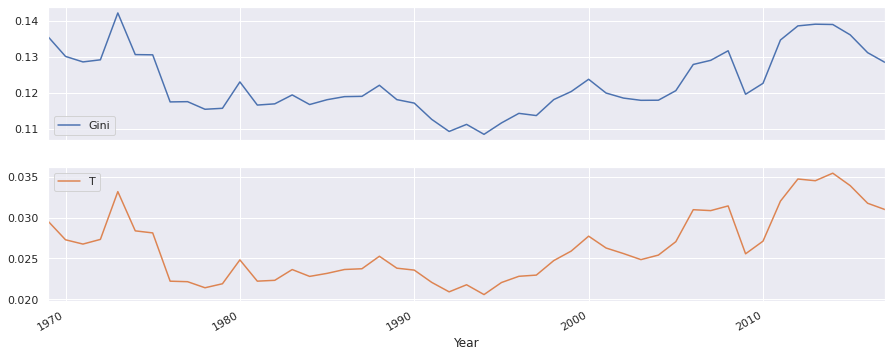

In [34]:
#gini_df.plot(figsize=(15,4))
_ = gini_df.plot(subplots=True, figsize=(15,6))
#gini_df.plot(y=['Gini', 'T'], figsize=(15,4))

The time paths of the Gini and the Theil coefficients show striking
similarities, and, at first glance, this might suggest that the indices are
substitutes for one another. As we shall see below, however, each index has
properties that lend themselves to particular spatial extensions that provide
important complementarities.

## Personal versus Regional Income
There is a subtle but important distinction between the study of personal and
regional income inequality. To see this, we first need to express the
relationships between the two types of inequality. Consider a country composed
of $N$ individuals who are distributed over $m$ regions. Let $Y_l$ denote the
income of individual $l$. Total personal income in region $i$ is given as $Y_i =
\sum_{l \in i} Y_l$. Per-capita income in region $i$ is $y_i = \frac{Y_i}{N_i}$,
where $N_i$ is the number of individuals in region $i$.

At the national level,  the coefficient of variation as an index of  interpersonal income inequality would be:

$$CV_{nat} = \sqrt{\frac{\sum_{l=1}^N (Y_l - \bar{y})^2}{N}}$$

where $\bar{y}$ is national per-capita income. The key component here is the sum
of squares term, and unpacking this sheds light on personal versus regional
inequality question:

$$TSS = \sum_{l=1}^N (Y_l - \bar{y})^2$$

Focusing on an individual deviation: $\delta_l = Y_l - \bar{y}$, this is the contribution to inequality associated with individual $l$. We can break this into two components:

$$\delta_l = (Y_l - y_i) +  (y_i - \bar{y})$$

The first term is the difference between the individual's income and per-capita income in the individual's region of residence, while the second term is the difference between the region's per capita income and average national per capita income.

In regional studies, the intraregional personal income distribution is typically
not available. As a result, the assumption is often made that intraregional
personal inequality is zero. In other words, all individuals in the same region
have identical incomes. With this assumption in hand, the first term vanishes:
$Y_l -y_i = 0$, leading to:[^reg] 

[^reg]: It should also be noted that even at the national scale, the analysis of interpersonal income inequality also relies on aggregate data grouping individuals into income cohorts. See, for example, {cite}`Piketty_2003`.

$$
\begin{aligned}
TSS &= \sum_{l=1}^N (Y_l - \bar{y})^2 \\
    &= \sum_{l=1}^N \delta_l^2 \\
    &= \sum_{l=1}^N ((Y_l - y_i) +  (y_i - \bar{y}))^2 \\
    &= \sum_{l=1}^N (0 +  (y_i - \bar{y}))^2 \\
    &= \sum_{i=1}^m\sum_{l \in i}  (y_i - \bar{y})^2 \\
    &= \sum_{i=1}^m  [N_i(y_i - \bar{y})]^2
\end{aligned}
$$

This means that each individual in a region has an equal contribution to the
overall level of national interpersonal inequality, given by $(y_i - \bar{y})$,
while the region in question contributes $N_i(y_i - \bar{y})$. While it may seem
that the assumption of zero intraregional interepersonal income inequality is
overly restrictive, it serves to isolate the nature of interregional income
inequality. That is, inequality between places, rather than inequality between
people within those places. In essence, this strategy shifts the question up one
level in the spatial hierarchy by aggregating micro-level individual data to
areal units.



## Spatial Inequality

The analysis of regional income inequality is distinguished from the analysis of
national interpersonal income inequality in its focus on spatial units. As
regional incomes are embedded in geographical space, it is important to consider
the special nature of spatial data. In the regional inequality literature this
has been approaches in a number of ways.

### Spatial Autocorrelation
To get some insights on the spatial properties of regional income data, we can
turn to global measures of spatial autocorrelation that we encountered in
chapter XX. We use a queen spatial weights matrix to calculate Moran's I for
each year in the sample.

In [36]:
wq = pysal.lib.weights.Queen.from_dataframe(pci_df)

In [37]:
wq.n

3076

In [38]:
MI = [pysal.explore.esda.moran.Moran(pci_df[str(y)], wq) for y in years]

In [39]:
res = np.array([ (mi.I, mi.p_sim) for mi in MI])

In [40]:
res.shape

(49, 2)

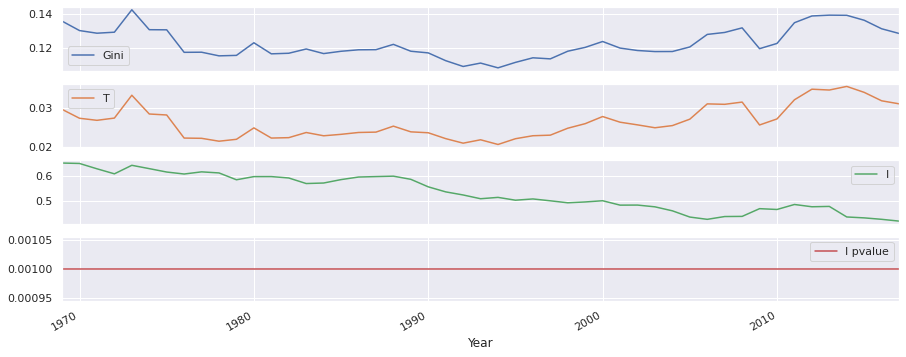

In [41]:
res_df = gini_df
res_df['I'] = res[:,0]
res_df['I pvalue'] = res[:,1]
_ = res_df[["Gini", "T", "I", "I pvalue"]].plot(subplots=True, figsize=(15,6))

In [42]:
res_df.columns

Index(['Gini', 'T', 'I', 'I pvalue'], dtype='object')

Several patterns emerge from the time series of Moran's I. First, the is a secular decline in the value of Moran's I. Second, despite this decline,  there is never a year in which the spatial autocorrelation is not statistically significant. In other words, there is a strong spatial structure in the distribution of regional incomes that needs to be accounted for when focusing on inequality questions.


### Decompositional Approaches

A popular approach to the analysis of inequality is to group the observations into mutually exclusive and exhaustive subsets in order to understand how much of the inequality is due to differences between members of the same subset versus between observations from different subsets. In the personal income literature, the groups have been defined in a number of ways: male vs. female, age cohorts, occupation types, race, etc. In regional applications, small areas are grouped into larger sets such that the resulting sets are spatially defined. **Add notions of connected components here and link to other chapters where appropriate.**


<!-- #region {"ein.tags": "worksheet-0", "slideshow": {"slide_type": "-"}} -->
### Regional Inequality Decompositions
One approach to incorporating spatial considerations into regional inequality extends this decompositional approach by using space to define the subgroups. This can be seen using   Theil's $T$, which we encountered previously and decomposing the index  into so called *between* and *within* regional inequality components.

Applied to a collection of observations on  per capita incomes for $m$ regional economies: $y = \left( y_1, y_2, \ldots, y_m \right)$, which are 
are grouped into $\omega$ mutually exclusive regions such that $\sum_{g=1}^{\omega} m_g=m$, where $m_g$ is the number of areas
assigned to region $g$, Theil's index from above can be rewritten as: 

$$
\begin{align}
T &= \sum_{i=1}^m \left( \frac{y_i}{\sum_{i=1}^m y_i} \ln \left[ m \frac{y_i}{\sum_{i=1}^m y_i}\right] \right) \\
  &= \left[ \sum_{g=1}^{\omega} s_{g} log(\frac{m}{m_g} s_g)  \right] + \left[ \sum_{g=1}^{\omega} s_g \sum_{i \in g} s_{i,g} log(m_g s_{i,g}) \right] \\
  &= B + W \\
\end{align}
$$

where $s_g = \frac{\sum_{i \in g} y_i}{\sum_i y_i}$, and   $s_{i,g} = y_i / \sum_{i \in g} y_i$. 

The first term is the between regions inequality component, and the second is
the within regions inequality component. The within region term is a weighted
average of inequality between economies belonging to the same region. Similar
to what is done above for the case of interpersonal inequality, the estimate of
the between region (group) component of the decomposition is based on setting
the incomes of all economies (individuals )belonging to a region (group) equal
to that of the regional (group) average of these per capita incomes. Now,
however, intraregional inequality between economies within the same region is
explicitly considered in the second component.[^weight]

[^weight]: The regional decomposition does not involve weighting the regions by their respective population. See  {cite}`Gluschenko_2018` for further details. 


In [43]:
pci_df.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'GeoFIPS', 'GeoName', 'Region',
       'TableName', 'LineCode', 'Descriptio', 'Unit', '1969', '1970', '1971',
       '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980',
       '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
       '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', 'index', 'IndustryCl', 'Descript_1', 'geometry'],
      dtype='object')

In [44]:
pandas.unique(pci_df['Region'])

array([3, 5, 8, 1, 2, 7, 4, 6])

<AxesSubplot:>

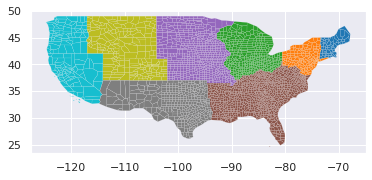

In [45]:
pci_df.plot(column='Region', categorical=True, linewidth=0.1)

In [46]:
region_df = pci_df.dissolve(by='STATEFP')

In [47]:
pandas.unique(region_df.Region)

array([5, 6, 8, 7, 1, 2, 3, 4])

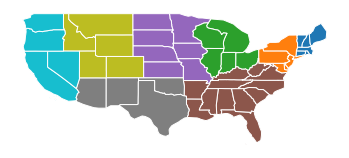

In [48]:
ax = region_df.plot(column='Region', categorical=True)
_ = ax.axis('off')

In [49]:
pci_df.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'GeoFIPS', 'GeoName', 'Region',
       'TableName', 'LineCode', 'Descriptio', 'Unit', '1969', '1970', '1971',
       '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980',
       '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
       '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', 'index', 'IndustryCl', 'Descript_1', 'geometry'],
      dtype='object')

In [50]:
region_names = ["New England",
               'Mideast', 'Great Lakes', 'Plains',
               'Southeast', 'Southwest', 'Rocky Mountain',
                'Far West']

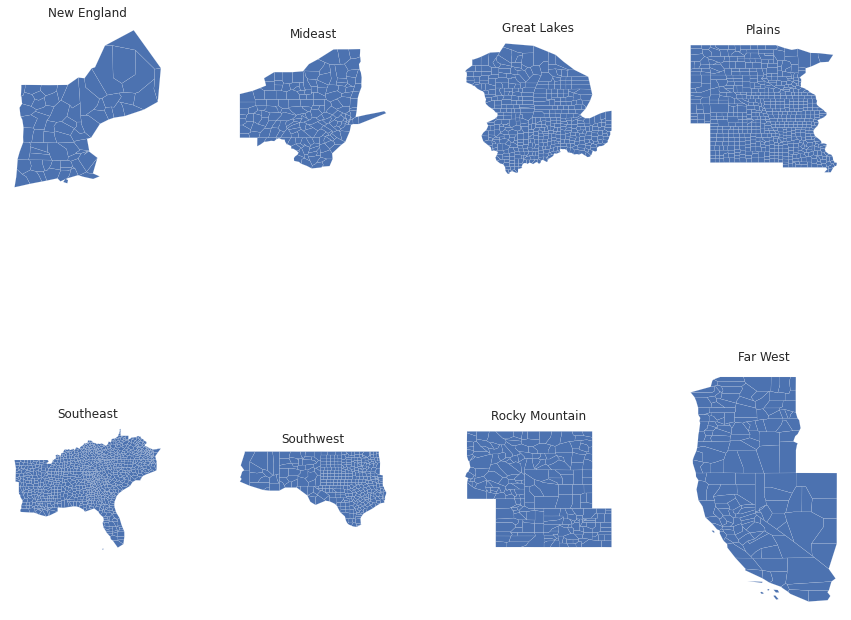

In [51]:
fig = plt.figure(figsize=(15,12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 9):
    ax = fig.add_subplot(2, 4, i)
    rdf = pci_df[pci_df.Region==i]
    rdf.plot(ax=ax, linewidth=0.1)
    ax.set_title(region_names[i-1])
    ax.axis('off')
    

In [52]:
pci_df.groupby('Region').mean()

,ALAND,AWATER,LineCode,1969,1970,1971,1972,1973,1974,1975,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,index
Region,,,,,,,,,,,,,,,,,,,,,
1,2.423518e+09,3.592977e+08,3.0,3736.208955,3984.611940,4238.238806,4567.477612,4959.328358,5338.358209,5740.134328,...,42780.895522,44309.119403,46358.701493,48058.731343,48107.701493,50086.671642,52201.611940,53493.805970,55414.552239,NaN
2,1.614247e+09,1.943027e+08,3.0,3745.112360,4003.943820,4263.578652,4608.359551,5073.617978,5534.668539,5994.792135,...,38791.646067,40084.056180,41977.707865,43304.949438,43733.797753,45401.174157,47022.191011,47930.286517,49987.123596,NaN
3,1.441214e+09,3.468585e+08,3.0,3426.800459,3575.077982,3863.880734,4199.541284,4795.082569,5156.715596,5668.309633,...,32334.279817,33621.401376,35712.176606,36784.635321,37842.667431,38810.309633,39864.006881,40735.772936,41918.071101,NaN
4,2.127329e+09,5.344987e+07,3.0,3185.181230,3463.689320,3748.909385,4273.289644,5462.899676,5389.299353,5774.113269,...,35053.728155,36949.754045,41725.169903,43098.207120,44535.634304,44770.778317,44949.200647,44198.533981,44367.509709,NaN
5,1.301742e+09,9.932303e+07,3.0,2611.549758,2829.139130,3062.237681,3388.372947,3833.672464,4187.850242,4487.303382,...,29590.113043,30387.192271,31792.254106,32852.524638,33231.090821,34305.962319,35476.280193,36012.045411,37209.981643,104.771429
6,3.842122e+09,6.343465e+07,3.0,2968.305040,3233.893899,3443.859416,3835.867374,4486.610080,4565.095491,5182.435013,...,30991.137931,33064.135279,35886.458886,37412.612732,38892.190981,41058.530504,40829.559682,39043.450928,40153.835544,NaN
7,6.158906e+09,7.368098e+07,3.0,3320.837209,3642.600000,3869.986047,4407.576744,5147.102326,5597.353488,5814.697674,...,33196.893023,34434.381395,37304.758140,39290.641860,40389.246512,42126.865116,43665.418605,43188.325581,44321.232558,NaN
8,7.392819e+09,2.725763e+08,3.0,4026.353333,4282.726667,4605.933333,5058.586667,5621.780000,6265.166667,6749.706667,...,35611.180000,36680.900000,38548.673333,39962.253333,40579.226667,42877.700000,45247.820000,46248.953333,47928.013333,NaN


In [53]:
regimes = pci_df['Region']
ys = [str(y) for y in years]

In [54]:
rmeans = pci_df.groupby(by='Region').mean().transpose()

In [55]:
rmeans.index

Index(['ALAND', 'AWATER', 'LineCode', '1969', '1970', '1971', '1972', '1973',
       '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982',
       '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991',
       '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000',
       '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
       '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       'index'],
      dtype='object')

In [56]:
rmeans = rmeans.loc[ys]

In [57]:
rmeans.columns = region_names

In [58]:
rmeans.head()

,New England,Mideast,Great Lakes,Plains,Southeast,Southwest,Rocky Mountain,Far West
1969,3736.208955,3745.112360,3426.800459,3185.181230,2611.549758,2968.305040,3320.837209,4026.353333
1970,3984.611940,4003.943820,3575.077982,3463.689320,2829.139130,3233.893899,3642.600000,4282.726667
1971,4238.238806,4263.578652,3863.880734,3748.909385,3062.237681,3443.859416,3869.986047,4605.933333
1972,4567.477612,4608.359551,4199.541284,4273.289644,3388.372947,3835.867374,4407.576744,5058.586667
1973,4959.328358,5073.617978,4795.082569,5462.899676,3833.672464,4486.610080,5147.102326,5621.780000


In [59]:
rmeans = pandas.DataFrame(rmeans)

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

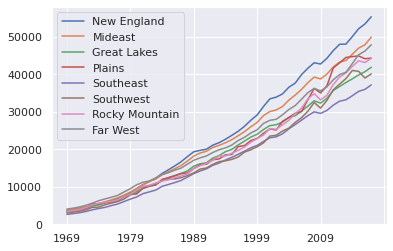

In [60]:
rmeans.plot.line()

## Regional Decomposition of Inequality

In [61]:
theil_dr = pysal.explore.inequality.theil.TheilD(pci_df[ys].values, regimes)

In [62]:
theil_dr.bg

array([0.00914353, 0.00822696, 0.00782675, 0.00768201, 0.01022634,
       0.0081274 , 0.00783943, 0.00572543, 0.00560271, 0.0054971 ,
       0.00511791, 0.00566001, 0.00486877, 0.00466134, 0.00474425,
       0.00424528, 0.00428434, 0.00453503, 0.00465829, 0.00456699,
       0.00467363, 0.00412391, 0.00366334, 0.00342112, 0.00327131,
       0.00312475, 0.00326071, 0.00359733, 0.00327591, 0.00363014,
       0.00382409, 0.00436261, 0.00399156, 0.00402506, 0.00397   ,
       0.00394649, 0.00353368, 0.00362698, 0.00400508, 0.00449814,
       0.0043533 , 0.00470988, 0.0063954 , 0.00642426, 0.00694236,
       0.00644971, 0.00591871, 0.00554072, 0.00528702])

In [63]:
res_df['bgr'] = theil_dr.bg
res_df['wgr'] = theil_dr.wg

array([<AxesSubplot:xlabel='Year'>, <AxesSubplot:xlabel='Year'>,
       <AxesSubplot:xlabel='Year'>, <AxesSubplot:xlabel='Year'>,
       <AxesSubplot:xlabel='Year'>, <AxesSubplot:xlabel='Year'>],
      dtype=object)

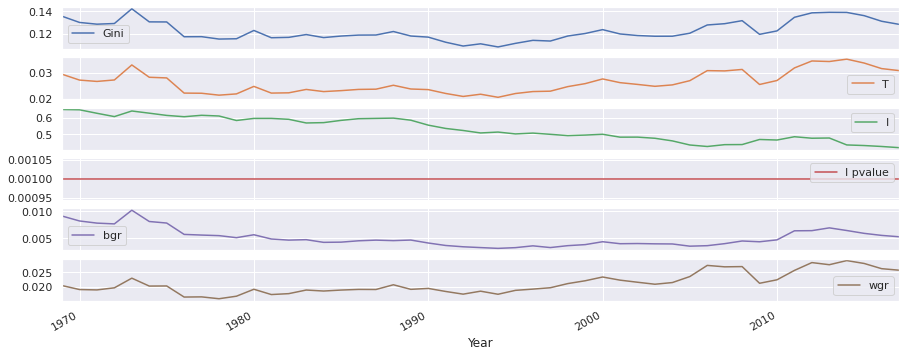

In [64]:
res_df.plot(subplots=True, figsize=(15,6))

In [65]:

numpy.random.seed(12345)
theil_drs = pysal.explore.inequality.theil.TheilDSim(pci_df[ys].values, regimes, 999)

array([<AxesSubplot:xlabel='Year'>, <AxesSubplot:xlabel='Year'>,
       <AxesSubplot:xlabel='Year'>, <AxesSubplot:xlabel='Year'>,
       <AxesSubplot:xlabel='Year'>, <AxesSubplot:xlabel='Year'>,
       <AxesSubplot:xlabel='Year'>], dtype=object)

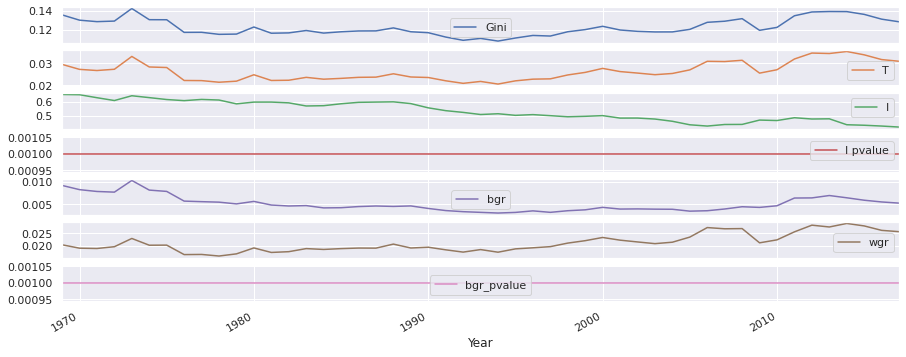

In [66]:
res_df['bgr_pvalue'] = theil_drs.bg_pvalue
res_df.plot(subplots=True, figsize=(15,6))

<AxesSubplot:xlabel='Year'>

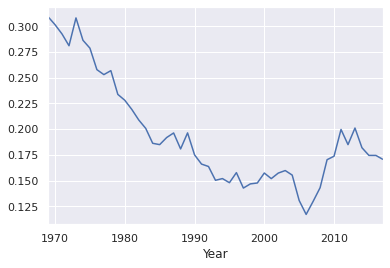

In [67]:
res_df['bgr_share'] = res_df['bgr'] / res_df['T']
res_df['bgr_share'].plot()

## Decomposition Using States

In [68]:
theil_ds = pysal.explore.inequality.theil.TheilD(pci_df[ys].values, pci_df['STATEFP'])

In [69]:
theil_ds.T

array([0.02957171, 0.02729024, 0.02676375, 0.02733643, 0.03319636,
       0.0283834 , 0.02813178, 0.02221109, 0.02214933, 0.0214058 ,
       0.02189626, 0.02482284, 0.02221437, 0.02231788, 0.02363836,
       0.02279897, 0.02317035, 0.02364545, 0.02373745, 0.02526876,
       0.02380707, 0.02357123, 0.02206676, 0.02090373, 0.02177284,
       0.02056993, 0.02204564, 0.02281087, 0.02295751, 0.02473775,
       0.02590456, 0.02773321, 0.02628126, 0.02559679, 0.02485643,
       0.02541131, 0.02705721, 0.03097819, 0.03086718, 0.03144127,
       0.02556892, 0.02712277, 0.03203084, 0.0347429 , 0.0345323 ,
       0.03545746, 0.03393143, 0.03176903, 0.03099292])

In [70]:
theil_ds.bg

array([0.01202777, 0.0109842 , 0.01061905, 0.01071478, 0.01461233,
       0.01174763, 0.01105986, 0.00815501, 0.00775988, 0.00777003,
       0.00712967, 0.00872701, 0.00756995, 0.00769952, 0.00794164,
       0.00740631, 0.0076062 , 0.00797162, 0.00823884, 0.00882419,
       0.00822823, 0.00749875, 0.00647523, 0.00599987, 0.00588984,
       0.00554096, 0.00588646, 0.00611652, 0.00608983, 0.00646834,
       0.00697106, 0.00771045, 0.00734962, 0.00735772, 0.00739003,
       0.00719904, 0.00701947, 0.00759011, 0.00812861, 0.0087168 ,
       0.00792982, 0.00889907, 0.01146766, 0.01226932, 0.01196   ,
       0.01128832, 0.01076909, 0.00978511, 0.00924435])

In [71]:
res_df['bgs_share'] = theil_ds.bg / theil_ds.T
res_df['bgs'] = theil_ds.bg

<AxesSubplot:xlabel='Year'>

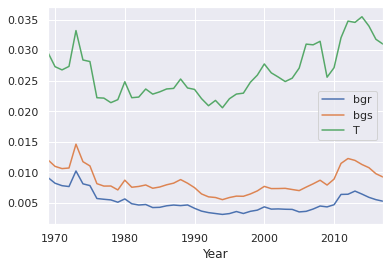

In [72]:
res_df[['bgr', 'bgs', 'T']].plot()

<AxesSubplot:xlabel='Year'>

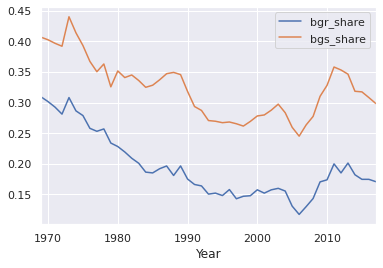

In [73]:
res_df[['bgr_share', 'bgs_share']].plot()

In [74]:
res_df[['bgr_share', 'bgs_share','T']].corr()

,bgr_share,bgs_share,T
bgr_share,1.000000,0.942346,0.057387
bgs_share,0.942346,1.000000,0.184088
T,0.057387,0.184088,1.000000


A few patterns emerge from these figures. First, inequality between the states is larger than inequality between regions. Second, inequality within states is smaller than inequality within regions. Third, the time series patterns for the interregional components are similar for the BEA regions and state partitions of the counties. Finally, the correlation of between share and overall inequality is higher at the state level than for the BEA region level

### Intraregional inequality
We can take a closer look at the within region inequality component by dissagregating the total value from XX into that occuring within each of the 8 regions. This can be done by calculating the global Theil index on the counties belonging to a given region.

In [75]:
region_names = ["New England",
               'Mideast', 'Great Lakes', 'Plains',
               'Southeast', 'Southwest', 'Rocky Mountain',
                'Far West']
results = []
table = []
for region in range(1, 9):
    rdf = pci_df[pci_df.Region==region]
    #rdf.plot()
    #print(region, len(pandas.unique(rdf.STATEFP)), rdf.shape[0])
    table.append([region, region_names[region-1], len(pandas.unique(rdf.STATEFP)), rdf.shape[0]])
    #results.append(pysal.explore.inequality.theil.TheilDSim(rdf[ys].values, rdf.STATEFP,999))
    

In [76]:
summary = pandas.DataFrame(table)

In [77]:
summary.columns = [ "Region", "Name", "States", "Counties"]

In [78]:
summary

,Region,Name,States,Counties
0,1,New England,6,67
1,2,Mideast,6,178
2,3,Great Lakes,5,436
3,4,Plains,7,618
4,5,Southeast,12,1035
5,6,Southwest,4,377
6,7,Rocky Mountain,5,215
7,8,Far West,4,150


In [79]:
region_names = ["New England",
               'Mideast', 'Great Lakes', 'Plains',
               'Southeast', 'Southwest', 'Rocky Mountain',
                'Far West']
results = []
table = []
for region in range(1, 9):
    rdf = pci_df[pci_df.Region==region]
    #rdf.plot()
    #print(region, len(pandas.unique(rdf.STATEFP)), rdf.shape[0])
    table.append([region, region_names[region-1], len(pandas.unique(rdf.STATEFP)), rdf.shape[0]])
    results.append(pysal.explore.inequality.theil.TheilDSim(rdf[ys].values, rdf.STATEFP,999))
    

In [80]:
len(results)

8

In [81]:
r1 = results[0]

In [82]:
r1.bg_pvalue

array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001])

In [83]:
Tr = pandas.DataFrame([result.T for result in results]).transpose()

In [84]:
Tr.head()

,0,1,2,3,4,5,6,7
0,0.014585,0.018776,0.012075,0.015233,0.028121,0.029590,0.018616,0.013005
1,0.013423,0.018680,0.010455,0.015837,0.024682,0.025866,0.020219,0.013539
2,0.013806,0.019843,0.010493,0.014355,0.024555,0.027463,0.018711,0.014485
3,0.014890,0.019747,0.010600,0.016188,0.023133,0.032705,0.019762,0.014310
4,0.012113,0.017861,0.011965,0.027926,0.020529,0.038443,0.027356,0.014854


In [85]:
Tr = Tr.rename(columns=dict([(i,name) for i,name in enumerate(region_names)]))

In [86]:
pinned0 = Tr.divide(Tr.iloc[0])

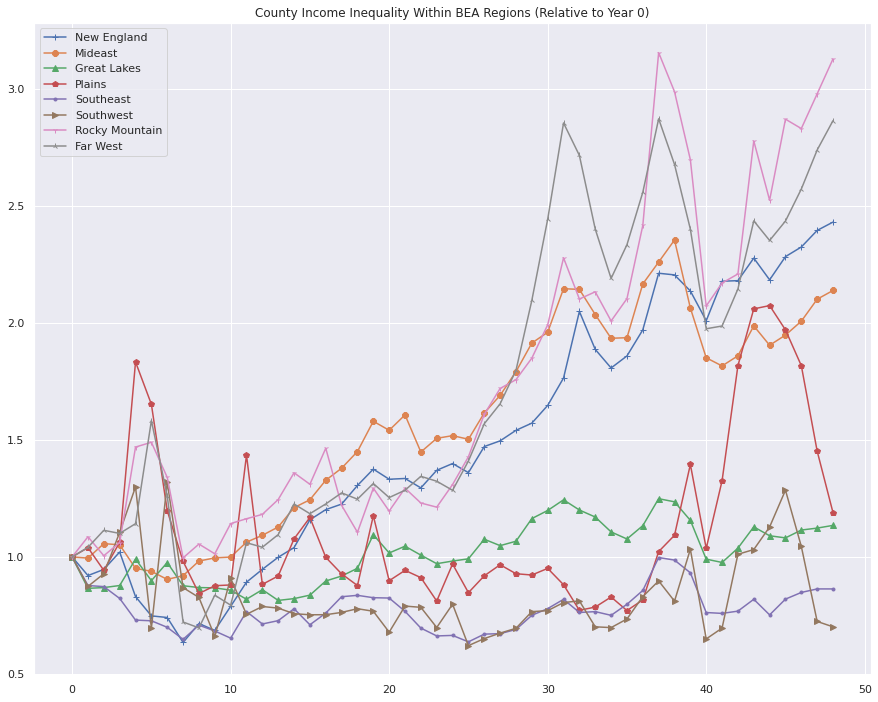

In [87]:
import pandas as pd

df = pinned0
markers = [ "+", "8", "^", "p", ".", ">", "1", '2']
ax = df.plot(kind='line', figsize=(15, 12))
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])

# for adding legend
ax.legend(ax.get_lines(), df.columns, loc='best')
_ = ax.set_title("County Income Inequality Within BEA Regions (Relative to Year 0)")

Unpacking the intraregional inequality term reveals that the original decomposition of inequality into within and between regions actually masks a great deal of heterogeneity in the internal inequality dynamics across the eight regions. Put another way, the overall trend in the aggregate within region component above is an average of the trends exhibited in each of the eight regions. There are two distinct groups of regions in this regard. The first consists of regions where the inequality between counties within each region has been increasing over the sample period. This group is composed of the New England,  Mideast, Far West, and Rocky Mountains regions. The second group are those regions where intraregional inequality has remained stable, or even decreased, over time. The Great Lakes, Southeast, and Southwest regions compose this group. The one outlier region is the Plains which does not fall neatly into either of these two groups.

### Regional Inequality Between States

We can also ask if there is spatial heterogeneity in the inequality between counties from different states across each of the eight regions. That is, do states matter more in different regions?

In [88]:
bs =  numpy.array([ r.bg[0]/ r.T for r in results]).T

In [89]:
bs.shape

(49, 8)

In [90]:
bs_df = pandas.DataFrame(bs, columns=region_names)

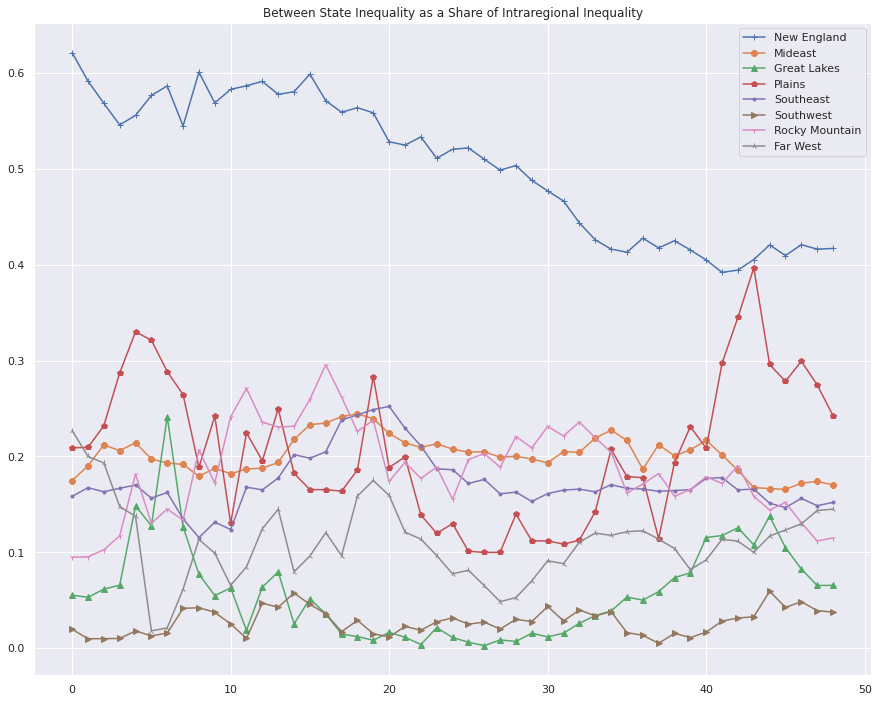

In [91]:
import pandas as pd


markers = [ "+", "8", "^", "p", ".", ">", "1", '2']
ax = bs_df.plot(kind='line', figsize=(15, 12))
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])

# for adding legend
ax.legend(ax.get_lines(), df.columns, loc='best')
_ = ax.set_title("Between State Inequality as a Share of Intraregional Inequality")

In general terms, there is much more similarity across the regions in terms of inequality between the states. The between state share of inequality is the smaller component of inequality between the counties within each of the regions with the exception of the New England region.

<!-- #region {"ein.tags": "worksheet-0", "slideshow": {"slide_type": "-"}} -->


### Spatializing Classic Measures

We now turn to two newer spatial analytics that extend a selction of the classic (a-spatial) inequality measures above to introduce a spatially explicit focus.

#### Spatial Gini

The first spatial extension was introduced by {cite}`Rey_2012` and is designed to consider
the role of adjacency in a decomposition of the Gini index of inequality. More
specifically, The Gini in mean  is
$$G = \frac{\sum_i \sum_j \left | x_i - x_j \right|}{2 n^2 \bar{x}} $$
and the spatial decomposition focuses on the numerator
$$
\sum_i \sum_j \left |x_i - x_j \right | = \sum_i \sum_j \left( w_{i,j} \left |x_i - x_j \right | \right ) + \left( (1-w_{i,j})  \left |x_i - x_j \right | \right )
$$
where $w_{i,j}$ is an element of a binary spatial weights matrix indicating if observations $i$ and $j$ are spatial neighbors. This results in

$$G = \frac{\sum_i \sum_j w_{i,j}\left | x_i - x_j \right|}{2 n^2 \bar{x}} +   \frac{\sum_i \sum_j \left (1-w_{i,j} )| x_i - x_j \right|}{2 n^2 \bar{x}}. $$

The spatial Iini allows for a consideration of the spatial dependence in inequality. As this dependence increases, the second term of the spatial Gini can be expected to grow relative to the case where incomes are randomly distributed in space. Inference on the spatial Gini can be based on random spatial permutations of the income values, as we have seen elsewhere in this book.

The spatial Gini also provides a useful complement to the regional decomposition used in the Theil statistic. The latter does not consider pair-wise relationships between observations, while the spatial Gini does.

In [92]:
from inequality.gini import Gini_Spatial

In [93]:
wq.transform = 'B'

The spatial Gini takes a vector of incomes and a spatial weights object:

In [94]:
gs69 = Gini_Spatial(pci_df['1969'], wq)

In [95]:
gs69.g

0.13556175504269904

In [96]:
gs69.p_sim

0.01

The value is statistically significant for 1969, indicating that inequality between neighboring pairs of counties is different from the inequality between county paris that are not geographically proximate.

We can apply the same statistic over each year in the sample:

In [97]:
gs = [Gini_Spatial(pci_df[y], wq) for y in ys]

In [98]:
gs_array = np.array([(gsi.e_wcg, gsi.wcg, gsi.z_wcg, gsi.p_sim) for gsi in gs])

Extracting the z-values for the spatial Gini we see that the spatial dependence in the inequality is signficant in every year of the sample:

<AxesSubplot:xlabel='Year'>

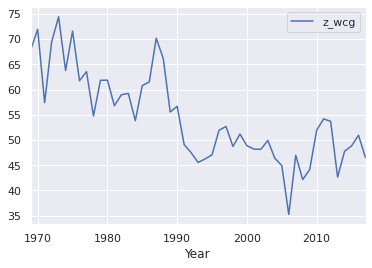

In [99]:
res_df['z_wcg'] = gs_array[:,2]
res_df.plot(y=['z_wcg'])

#### Spatial 20:20
The final analytics that we examine in this notebook are based on extending the classic 20:20 ratio to develop spatial visualizations.
As was seen earlier, the 20:20 ratio measures the gap in the incomes between the counties at the 80th and 20th percentiles of the income distirbution.
In the spatial 20:20 analytic, we can visualize and measure the geographical gap (separation) between these pair of counties.


In [100]:
ranks = pci_df.rank()

In [101]:
for year in years:
    pci_df["{}_rank".format(year)] = pci_df[str(year)].rank(method='first')

In [102]:
ridx_20 = int(.2 * 3077)
ridx_80 = int(.8 * 3077)
ridx_20, ridx_80

(615, 2461)

In [103]:
df = pci_df

In [104]:
df['1969_rank']

0       2690.0
1       2208.0
2       1971.0
3       1040.0
4        992.0
         ...  
3071    1598.0
3072    3019.0
3073     635.0
3074    1924.0
3075    2848.0
Name: 1969_rank, Length: 3076, dtype: float64

In [105]:
df.index[df['1969_rank']==615].tolist()

[2998]

In [106]:
idx_20 = []
idx_80 = []
for year in years:
    column = "{}_rank".format(year)
    idx_20_i = df.index[df[column]==ridx_20]
    idx_20.extend(idx_20_i)
    idx_80_i = df.index[df[column]==ridx_80]
    idx_80.extend(idx_80_i)

As an example of the spatial 20:20 view, we plot the pair of counties at the 20th and 80th percentile for the last period of the sample:

<AxesSubplot:>

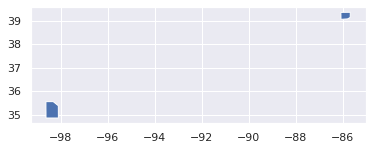

In [107]:
df.loc[[idx_20[-1], idx_80[-1]], :].plot()

Because we will be interested in measuring the spatial separation between the 20:20 counties each period, we set the coordinate reference system:

In [108]:
import geopandas as gpd
from shapely.geometry import Point,Polygon
geom=[Point(xy) for xy in zip([117.454361,117.459880],[38.8459879,38.846255])]
ldf=gpd.GeoDataFrame(geometry=geom,crs={'init':'epsg:4326'})
ldf.to_crs(epsg=3310,inplace=True)
l=gdf.distance(ldf.shift())

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/lib/python3.7/site-packages/geopandas/base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


In [111]:
ldf = df.to_crs({'init':'epsg:4326'})

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

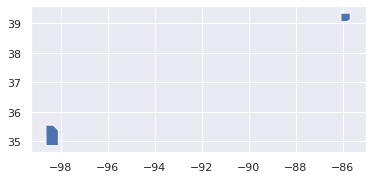

In [112]:
ldf.loc[[idx_20[-1], idx_80[-1]], :].plot()

In [113]:
ldf.to_crs(epsg=3310,inplace=True)


<AxesSubplot:>

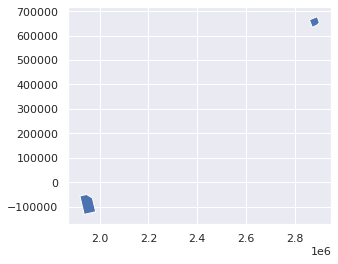

In [114]:
ldf.loc[[idx_20[-1], idx_80[-1]], :].plot()

In [115]:
small = ldf.loc[[idx_20[-1], idx_80[-1]], :]

In [116]:
small

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2008_rank,2009_rank,2010_rank,2011_rank,2012_rank,2013_rank,2014_rank,2015_rank,2016_rank,2017_rank
2067,40,015,01101795,40015,Caddo,Caddo County,06,H1,G4020,None,...,443.0,368.0,413.0,565.0,677.0,793.0,911.0,671.0,336.0,615.0
680,18,005,00451683,18005,Bartholomew,Bartholomew County,06,H1,G4020,294,...,2420.0,2307.0,2329.0,2283.0,2418.0,2270.0,2359.0,2362.0,2404.0,2461.0


In [117]:
small.distance(small.shift()).values[-1]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3310
Right CRS: None

  """Entry point for launching an IPython kernel.


1139415.4938111473

In [118]:
small.geometry.centroid

2067    POINT (1951308.635 -90787.343)
680     POINT (2879874.101 656267.341)
dtype: geometry

In [119]:
idxs = zip(idx_20, idx_80)
distances = []
for idx in idxs:
    o,d = idx
    #print(o,d, idx)
    pair = df.loc[idx, :]
    d = pair.distance(pair.shift()).values[-1]
    distances.append(d)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: None

  import sys


Visualizing the  plot the of the 20:20 distances, reveals a secular decline in the distances separating these pair of counties over time:

In [120]:
idxs = zip(idx_20, idx_80)

len(distances), len(years), len(list(idxs))
gini_df['s_dist'] = numpy.array(distances)

<AxesSubplot:xlabel='Year'>

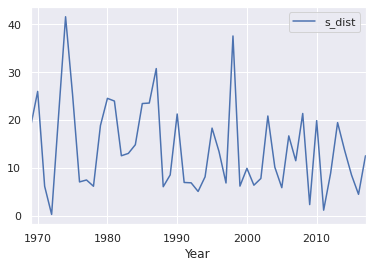

In [121]:
gini_df.plot(y=["s_dist"])

## Rank paths
A final analytic that we use to examine the spatial distribution of inequality across US counties is the evolution of the rank paths for the 20:20 ratio.
The rank path traces out the migration of a particular rank in the county income distribution over time {cite}`Rey_2020`. To construct the rank paths for the 20:20 counties, we first plot the centroids:

In [122]:
idxs = numpy.array(list(zip(idx_20, idx_80)))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


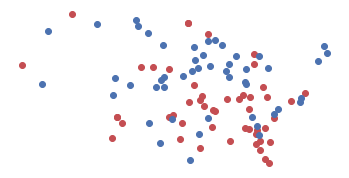

In [123]:

fig, ax = plt.subplots(1, 1, sharex='col', sharey='row')
df.loc[idxs[:,0],:].centroid.plot(ax=ax, color='r')
df.loc[idxs[:,1],:].centroid.plot(ax=ax, color='b')
ax.set_axis_off()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


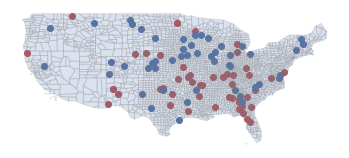

In [124]:

fig, ax = plt.subplots(1, 1, sharex='col', sharey='row')
df.loc[idxs[:,0],:].centroid.plot(ax=ax, color='r')
df.loc[idxs[:,1],:].centroid.plot(ax=ax, color='b')
gdf.plot(ax=ax,edgecolor='gray', alpha=0.2)
ax.set_axis_off()

Next, a directed edge connects the centroids of the two states that held a specific rank in a pair of consecutive periods.  

In [125]:
from shapely.geometry import LineString

In [126]:
ls20 = geopandas.GeoSeries(LineString(df.loc[idxs[:,0],:].centroid.tolist()))
ls80 = geopandas.GeoSeries(LineString(df.loc[idxs[:,1],:].centroid.tolist()))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


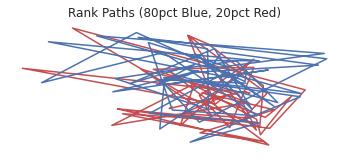

In [127]:

fig, ax = plt.subplots(1, 1, sharex='col', sharey='row')
ls20.plot(ax=ax, color='r', label='20p')
ls80.plot(ax=ax, color='b')
#gdf.plot(ax=ax,edgecolor='gray', alpha=0.2)
plt.title('Rank Paths (80pct Blue, 20pct Red)')
ax.set_axis_off()

The rank paths can also be constructed using a moving temporal window to provide a view of the evolution of the rank migrations over subsets of the sample period. Here we do so using a window of five years:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Geometry is in a geographic CRS. Resul

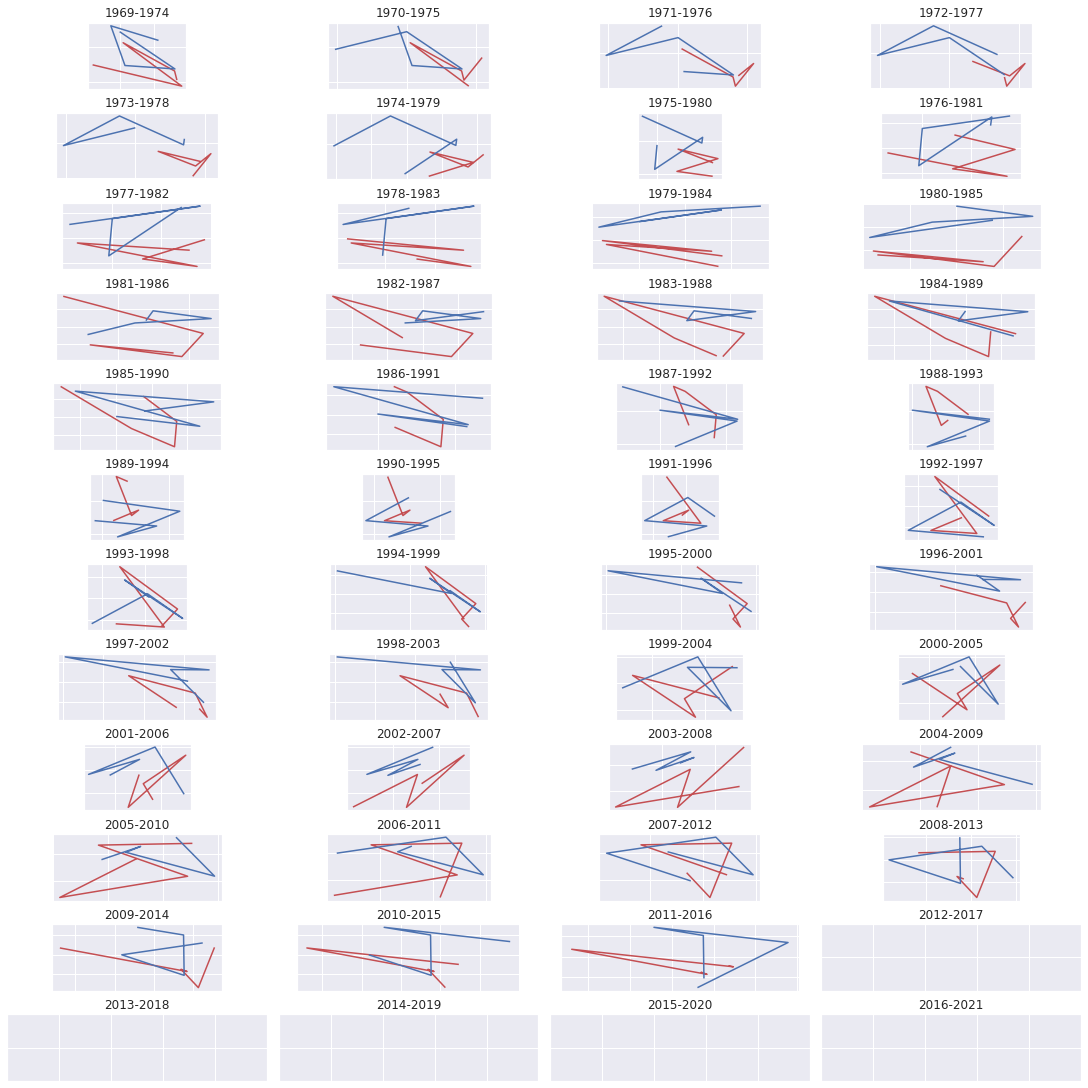

In [128]:
columns = 4
rows = 12
fig, ax_array = plt.subplots(rows, columns, squeeze=False, figsize=(15,15), constrained_layout=True)
year=0
for i,ax_row in enumerate(ax_array):
    for j,axes in enumerate(ax_row):
        axes.set_title('{}-{}'.format(1969+year, 1969+year+5))
        axes.set_yticklabels([])
        axes.set_xticklabels([])
        if year < 43:
            ls20 = geopandas.GeoSeries(LineString(df.loc[idxs[:,0],:].centroid.tolist()[year:year+5]))
            ls20.plot(ax=axes, color='r', label='20p')
            ls80 = geopandas.GeoSeries(LineString(df.loc[idxs[:,1],:].centroid.tolist()[year:year+5]))
            ls80.plot(ax=axes, color='b', label='20p')
    
        year += 1
plt.show()

Overall, there is a general north-south split for the 20 and 80 rank paths, with the wealthier part of the distribution being located more often in the northern section of the country.
